In [1]:
import argparse 

In [2]:
ap = argparse.ArgumentParser()

In [ ]:
ap.add_argument()

In [3]:
class A:
    def __init__(self, x, y):
        self.x = x
        self.y = y
a = A(1, 2)

In [4]:
a.x

1

In [5]:
a.y

2

In [6]:
vars(a)

{'x': 1, 'y': 2}

In [7]:
vars()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import argparse ',
  'ap = argparse.ArgumentParser()',
  'class A:\n    def __init__(self, x, y):\n        self.x = x\n        self.y = y\na = A(1, 2)',
  'a.x',
  'a.y',
  'vars(a)',
  'vars()'],
 '_oh': {4: 1, 5: 2, 6: {'x': 1, 'y': 2}},
 '_dh': ['D:\\AIoT-深度学习视频版\\基于opencv的机器视觉\\day21_图像分割与修复(一)\\代码'],
 'In': ['',
  'import argparse ',
  'ap = argparse.ArgumentParser()',
  'class A:\n    def __init__(self, x, y):\n        self.x = x\n        self.y = y\na = A(1, 2)',
  'a.x',
  'a.y',
  'vars(a)',
  'vars()'],
 'Out': {4: 1, 5: 2, 6: {'x': 1, 'y': 2}},
 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x000001BA4BC897F0>>,
 'exit': <IPython.core.a

In [8]:
globals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import argparse ',
  'ap = argparse.ArgumentParser()',
  'class A:\n    def __init__(self, x, y):\n        self.x = x\n        self.y = y\na = A(1, 2)',
  'a.x',
  'a.y',
  'vars(a)',
  'vars()',
  'globals()'],
 '_oh': {4: 1, 5: 2, 6: {'x': 1, 'y': 2}, 7: {...}},
 '_dh': ['D:\\AIoT-深度学习视频版\\基于opencv的机器视觉\\day21_图像分割与修复(一)\\代码'],
 'In': ['',
  'import argparse ',
  'ap = argparse.ArgumentParser()',
  'class A:\n    def __init__(self, x, y):\n        self.x = x\n        self.y = y\na = A(1, 2)',
  'a.x',
  'a.y',
  'vars(a)',
  'vars()',
  'globals()'],
 'Out': {4: 1, 5: 2, 6: {'x': 1, 'y': 2}, 7: {...}},
 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object

In [10]:
# 封装显示图片的函数
def cv_show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

24
0


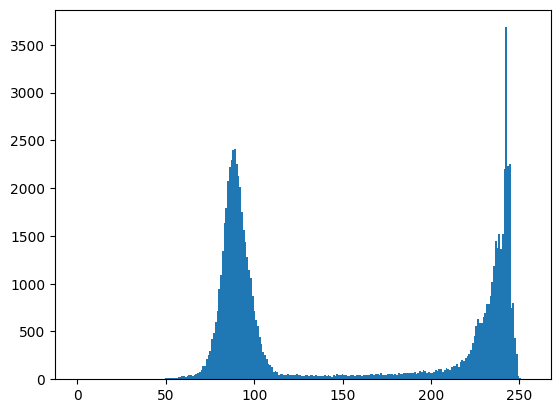

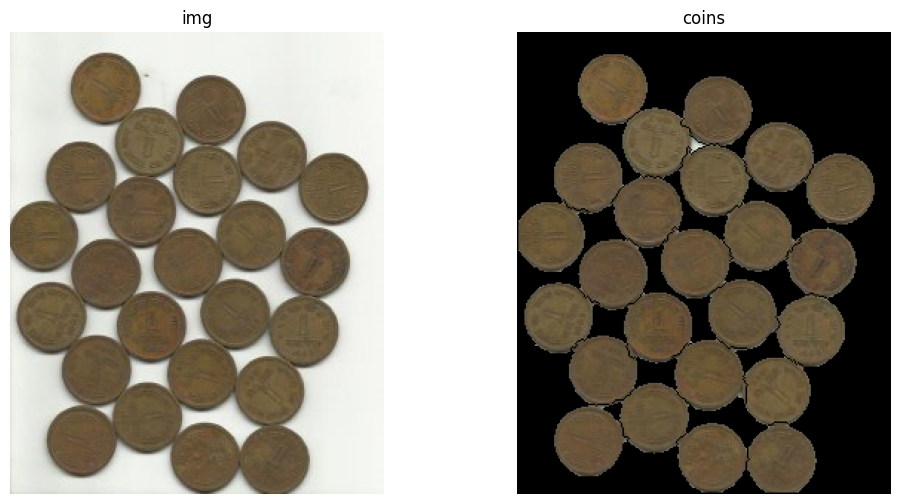

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('water_coins.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# cv_show('gray', gray)

_ = plt.hist(gray.ravel(), bins=256, range=[0, 255])
# 二值化处理, 这是一个典型的双峰结构, 我们使用大津算法进行二值化处理
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# 发现二值化之后的图片, 存在毛边, 和一些小的噪点.
# cv_show('thresh', thresh)
# 做一个开运算.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# cv_show('opening', opening)

# 想办法找到图中的背景和前景.
# 对opening进行膨胀. 
bg = cv2.dilate(opening, kernel, iterations=2)
# cv_show('bg', np.hstack((opening, bg)))

# 腐蚀, 
fg = cv2.erode(opening, kernel, iterations=2)
# cv_show('fg', np.hstack((opening, bg, fg)))
# 剩下的区域(硬币边界附近)不能确定是背景还是前景. 
# 可以通过膨胀之后的图减去腐蚀之后的图, 得到未知区域大小.
unknown = cv2.subtract(bg, fg)
cv_show('unknown', np.hstack((opening, bg, fg, unknown)))

# 因为硬币之间彼此是接触的, 导致腐蚀之后的前景图不太对, 硬币和硬币之间形成了通道.
# 腐蚀在这里不适合. 
# distanceTransform来确定前景. 
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# print(dist_transform.max())
# 对dist_transform做归一化方便展示结果
cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
# cv_show('dist_transform', dist_transform)

# 对dist_transform做二值化处理
_, fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
# cv_show('fg', fg)
# print(fg)
fg = np.uint8(fg)
# 顺便把未知区域算出
unknown = cv2.subtract(bg, fg)
# cv_show('gg', np.hstack((bg, fg, unknown)))
# connectedComponents要求输入的图片是个8位的单通道图片, 即单通道的0到255的图片.
# connectedComponents用0 来标记背景, 用大于0的整数来标记前景
_, markers = cv2.connectedComponents(fg)
print(markers.max())
print(markers.min())

# 因为watershed中0认为是不确定区域, 1是背景, 大于1的是前景.
# markers + 1把原来的0变成1了. 
markers += 1
# 从markers中筛选出位置区域, 赋值为0.
markers[unknown == 255] = 0
# 展示markers
markers_copy = markers.copy()
# 位置区域
markers_copy[markers == 0] = 150
# 背景
markers_copy[markers == 1] = 0
# 前景
markers_copy[markers > 1] = 255
markers_copy = np.uint8(markers_copy)
# cv_show('markers_copy', markers_copy)

# 到此为止, 我们的markers就已经生成好了. 
# watershed返回的markers已经做了修改. 边界区域标记为-1了. 
markers = cv2.watershed(img, markers)
# print(markers.min(), markers.max())
# 显示一下前景图片的边缘
# img[markers == -1] = [0, 0, 255]
# 单独取出或者标记出前景
# img[markers > 1] = [0, 255, 0]
# coins = img[markers > 1].copy()
# 抠出硬币
# mask把要抠图的地方赋值为255, 其他位置, 即背景赋值为0
mask = np.zeros(shape=img.shape[:2], dtype=np.uint8)
mask[markers > 1] = 255
coins = cv2.bitwise_and(img, img, mask=mask)

plt.figure(figsize=[12,6]);
plt.subplot(121); plt.imshow(img[:,:,::-1]);plt.axis('off');plt.title("img");
plt.subplot(122); plt.imshow(coins[:,:,::-1]);plt.axis('off');plt.title("coins");
# 把分水岭算法和边缘检测Canny和轮廓查找做个对比. 

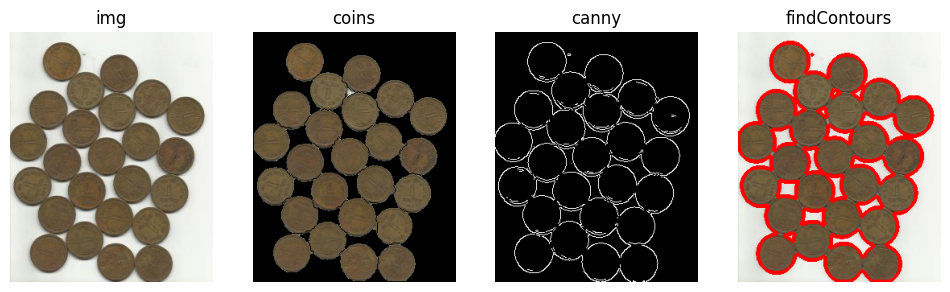

In [24]:
img_canny = cv2.Canny(img, 100, 150)
# 3. 使用findContours查找轮廓，复习一下以前的内容
img2 = cv2.imread('water_coins.jpeg')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# 二值化
_, thresh2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# findContours要求是单通道, 0到255的整数的图片, 最好是二值化的图片. 
contours, _ = cv2.findContours(thresh2, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# 显示轮廓, 会直接修改img2
cv2.drawContours(img2, contours, -1, (0, 0, 255), 3)


plt.figure(figsize=[12,6]);
plt.subplot(141); plt.imshow(img[:,:,::-1]);plt.axis('off');plt.title("img");
plt.subplot(142); plt.imshow(coins[:,:,::-1]);plt.axis('off');plt.title("coins");
plt.subplot(143); plt.imshow(img_canny,cmap='gray');plt.axis('off');plt.title("canny");		
plt.subplot(144); plt.imshow(img2[:,:,::-1]);plt.axis('off');plt.title("findContours");

In [11]:
# 和canny对比
imgs= cv2.imread('water_coins.jpeg')

cv_show('img_canny', img_canny)

In [20]:
# 和findContours对比
# 把img变成灰度图
img2 = cv2.imread('water_coins.jpeg')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 二值化
_, thresh2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv_show('gray', np.hstack((gray2, thresh2)))
# findContours要求是单通道, 0到255的整数的图片, 最好是二值化的图片. 
contours, _ = cv2.findContours(thresh2, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# 显示轮廓, 会直接修改img
cv2.drawContours(img2, contours, -1, (0, 0, 255), 3)
cv_show('contours', img2)

In [ ]:
img

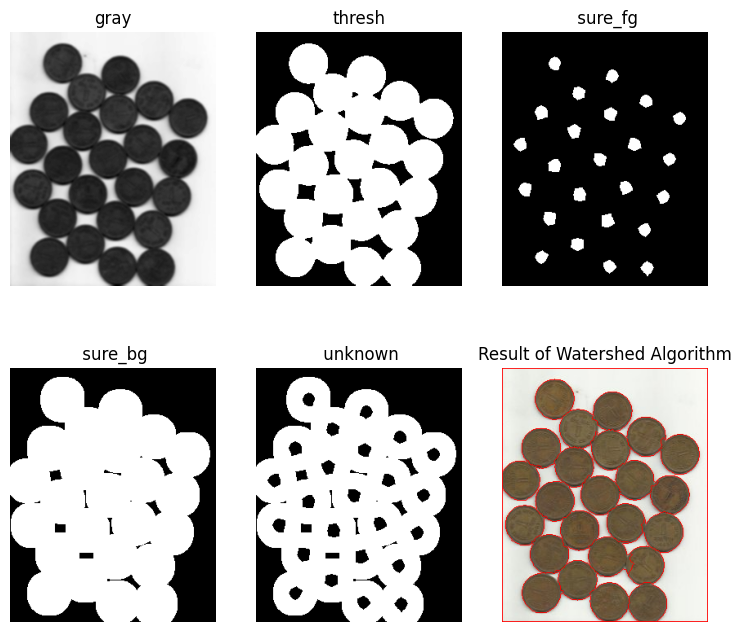

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 读取图像
img = cv2.imread('water_coins.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. 图像预处理 - 高斯模糊
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. 阈值分割 - 获取二值图像
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 3. 距离变换 - 提取前景物体
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# 4. 获取背景
sure_bg = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=3)

# 5. 获取未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# 6. 标记Marker
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# 7. 应用分水岭算法
markers = cv2.watershed(img, markers)

# 标记分水岭边界
img[markers == -1] = [0, 0, 255]

# 显示结果
plt.figure(figsize=[9,8]);
plt.subplot(231);plt.imshow(gray,cmap='gray');plt.title("gray");plt.axis('off');
plt.subplot(232);plt.imshow(thresh,cmap='gray');plt.title("thresh");plt.axis('off');
plt.subplot(233);plt.imshow(sure_fg,cmap='gray');plt.title(" sure_fg");plt.axis('off');
plt.subplot(234);plt.imshow(sure_bg,cmap='gray');plt.title(" sure_bg");plt.axis('off');
plt.subplot(235);plt.imshow(unknown,cmap='gray');plt.title(" unknown");plt.axis('off');
plt.subplot(236);plt.imshow(img[:,:,::-1]);plt.title("Result of Watershed Algorithm");plt.axis('off');